This is an attempt to create a Julia version of the [computational appendix](https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/web-appendix.pdf) in Rawlings [Reactor Design Book](https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/). 

In [2]:
using JuMP
using Plots
import Ipopt
using LabelledArrays
import DifferentialEquations as de
using DifferentialEquations
using Sundials
using DiffEqSensitivity
using ForwardDiff

In [104]:
K1 = 108.0
K2 = 284.0
P = 2.5
yI0 = 0.5
yB0 = 0.5
yP10 = 0.0
yP20 = 0.0

0.0

In [ ]:
model = Model(Ipopt.Optimizer)

In [ ]:
@variables(model, begin
            x1
            x2
            yI
            yB
            yP1
            yP2
            d
         end
         )

In [ ]:
@NLobjective(model, Min, 0.0)

In [ ]:
@constraint(model, d == 1.0 - x1 - x2)

In [ ]:
@NLconstraint(model, d * yI == yI0 - x1 - x2)
@NLconstraint(model, d * yB == yB0 - x1 - x2)
@NLconstraint(model, d * yP1 == yP10 + x1)
@NLconstraint(model, d * yP2 == yP20 + x2)

In [ ]:
@NLconstraint(model, P*K1*yI*yB - yP1 == 0.0)
@NLconstraint(model, P*K2*yI*yB - yP2 == 0.0)

In [ ]:
optimize!(model)

In [ ]:
println("""
termination_status = $(termination_status(model))
primal_status      = $(primal_status(model))
objective_value    = $(objective_value(model))
""")

In [ ]:
println("""x1 = $(value(x1)), x2 = $(value(x2))""")

In [ ]:
dg1 = -3.72e3
dg2 = -4.49e3
T = 400
R = 1.987
P = 2.5

In [ ]:
K1 = exp(-dg1 / (R * T))
K2 = exp(-dg2 / (R * T))
yI0 = 0.5
yB0 = 0.5
yP10 = 0.0
yP20 = 0.0

In [ ]:
model = Model(Ipopt.Optimizer)

In [ ]:
@variables(model,begin
            x1 >= 0.0, (start = 0.2)
            x2 >= 0.0, (start = 0.2)
            yI, (start = 0.2)
            yB, (start = 0.2)
            yP1, (start = 0.2)
            yP2, (start = 0.2)
            d, (start = 0.2)
         end          
         )

In [ ]:
@NLconstraint(model, d * yI == yI0 - x1 - x2)
@NLconstraint(model, d * yB == yB0 - x1 - x2)
@NLconstraint(model, d * yP1 == yP10 + x1)
@NLconstraint(model, d * yP2 == yP20 + x2)

In [ ]:
@constraint(model, d == 1.0 - x1 - x2)
@constraint(model, x1 + x2 <= 0.5)

In [ ]:
@NLobjective(model, Min, -(x1 * log(K1) + x2 * log(K2)) + d * log(P) +
          yI * d * log(yI) + yB * d * log(yB) +
          yP1 * d * log(yP1) + yP2 * d * log(yP2))

In [ ]:
optimize!(model)

In [ ]:
println("""
termination_status = $(termination_status(model))
primal_status      = $(primal_status(model))
objective_value    = $(objective_value(model))
""")

In [ ]:
println("""x1 = $(value(x1)), x2 = $(value(x2))""")

In [ ]:
function geval(x)
    dg1 = -3.72e3
    dg2 = -4.49e3
    T = 400
    R = 1.987
    P = 2.5
    
    K1 = exp(-dg1 / (R * T))
    K2 = exp(-dg2 / (R * T))
    yI0 = 0.5
    yB0 = 0.5
    yP10 = 0.0
    yP20 = 0.0
    
    d = 1.0 - x[1] - x[2]
    yI = (yI0 - x[1] - x[2])/d
    yB = (yB0 - x[1] - x[2])/d
    yP1 = (yP10 + x[1]) / d
    yP2 = (yP20 + x[2]) / d
    
    gval = -(x[1]*log(K1) + x[2]*log(K2)) + d * log(P) +
            yI * d * log(yI) + yB * d * log(yB) + 
            yP1 * d * log(yP1) + yP2 * d * log(yP2)
    return gval
end

In [ ]:
x1_l = 0.005:0.005:0.5
glist = fill(0.0, length(x1_l), length(x1_l))
for (i, x1) in enumerate(x1_l)
    x2_l = 0.005:0.005:(0.495 - x1)
    for (j, x2) in enumerate(x2_l)
        glist[i, j] = geval([x1, x2])
    end
end

In [ ]:
minimum(glist)

In [ ]:
contour(x1_l, x1_l, glist', levels = [0.0, -1.0, -2.0, -2.53, -2.55, -2.59])

## Ordinary Differential Equations

In [40]:
p = SLVector((
    NBf = 60.0e3,
    R = 0.08205,
    T = 1033.0,
    P = 1.0,
    k1 = 7.0e5,
    k2 = 4.0e5,
    K1 = 0.31,
    K2 = 0.48   
        ))

8-element SLArray{Tuple{8}, Float64, 1, 8, (:NBf, :R, :T, :P, :k1, :k2, :K1, :K2)} with indices SOneTo(8):
 :NBf => 60000.0
   :R => 0.08205
   :T => 1033.0
   :P => 1.0
  :k1 => 700000.0
  :k2 => 400000.0
  :K1 => 0.31
  :K2 => 0.48

In [41]:
function xdot!(dext, ext, p, v)
    NB = p.NBf - 2*ext[1] - ext[2]
    ND = ext[1] - ext[2]
    NH = ext[1] + ext[2]
    NT = ext[2]
    Q = p.NBf * p.R * p.T / p.P
    cB = NB / Q
    cD = ND / Q
    cH = NH / Q
    cT = NT / Q
    dext[1] = p.k1 * (cB * cB - cD * cH / p.K1)
    dext[2] = p.k2 * (cB * cD - cT * cH / p.K2)
end

xdot! (generic function with 1 method)

In [48]:
ext0 = [0.0, 0.0]
vspan = (0.0, 1600.0)

(0.0, 1600.0)

In [58]:
prob = ODEProblem(xdot!, ext0, vspan, p)
sol = de.solve(prob, Rodas4())

retcode: Success
Interpolation: specialized 3rd order "free" stiffness-aware interpolation
t: 32-element Vector{Float64}:
    0.0
    9.999999999999999e-5
    0.0010999999999999998
    0.011099999999999997
    0.11109999999999996
    0.41899167885700245
    1.0048478199647597
    1.9542705623327785
    3.4205187637984684
    5.582596679385624
    8.655673963960684
   12.88197439027192
   18.534430710491755
    ⋮
  160.2796165203439
  198.72609726242598
  245.15444897921904
  301.50766328721284
  370.3749718374365
  455.0409919547401
  559.2645510319473
  687.3261126630911
  845.4914459005089
 1044.01531731131
 1297.254470087749
 1600.0
u: 32-element Vector{Vector{Float64}}:
 [0.0, 0.0]
 [0.009744063043051449, 4.521275343295342e-10]
 [0.10718434533613048, 5.470717781052132e-8]
 [1.0815523553813309, 5.570379031926199e-6]
 [10.821752025068879, 0.0005577831816612893]
 [40.771317251152794, 0.007921874101652439]
 [97.59418319232023, 0.04544003075885472]
 [189.22191698055974, 0.17111935483699

In [59]:
conv = [(2*u[1] + u[2])/p.NBf for u in sol.u]
yB = [(p.NBf - 2*u[1] - u[2])/p.NBf for u in sol.u]
yD = [(u[1] - u[2])/p.NBf for u in sol.u]
yT = [u[2]/p.NBf for u in sol.u]
yH = [(u[1] + u[2])/p.NBf for u in sol.u]

32-element Vector{Float64}:
 0.0
 1.6240105825298306e-7
 1.7864066673884716e-6
 1.802596542933938e-5
 0.000180371830137509
 0.0006796539854209075
 0.0016273270537179847
 0.0031565506055899455
 0.005502389106774626
 0.008926712310028477
 0.013723452601273363
 0.020187511677862306
 0.028598250022939194
 ⋮
 0.1724337111390517
 0.19578765178206403
 0.21837414267028166
 0.23949180972115192
 0.25852492835680707
 0.27500974434170605
 0.2887242425891163
 0.29981902929673504
 0.30882518579215795
 0.31639095263299954
 0.32294688792471754
 0.32823666311000643

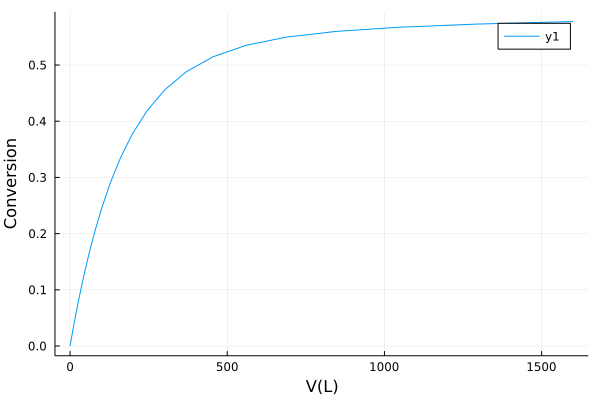

In [60]:
plot(sol.t, conv, xlabel = "V(L)", ylabel = "Conversion")

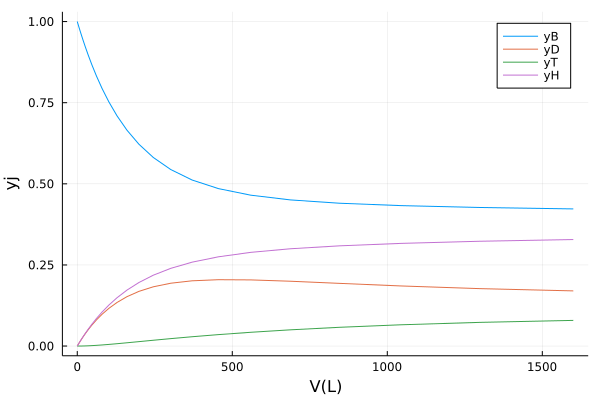

In [61]:
plot(sol.t, [yB, yD, yT, yH], labels = ["yB" "yD" "yT" "yH"], xlabel = "V(L)", ylabel = "yj")

## Differential-Algebraic Equations

In [81]:
p = SLVector((
    NBf = 60.0e3,
    R = 0.08205,
    T = 1033.0,
    P = 1.0,
    k1 = 7.0e5,
    k2 = 4.0e5,
    K1 = 0.31,
    K2 = 0.48   
        ))

8-element SLArray{Tuple{8}, Float64, 1, 8, (:NBf, :R, :T, :P, :k1, :k2, :K1, :K2)} with indices SOneTo(8):
 :NBf => 60000.0
   :R => 0.08205
   :T => 1033.0
   :P => 1.0
  :k1 => 700000.0
  :k2 => 400000.0
  :K1 => 0.31
  :K2 => 0.48

In [82]:
function xdot_dae!(res, dext, ext, p, v)
    NB = p.NBf - 2*ext[1] - ext[2]
    ND = ext[1] - ext[2]
    NH = ext[1] + ext[2]
    NT = ext[2]
    Q = p.NBf * p.R * p.T / p.P
    cB = NB / Q
    cD = ND / Q
    cH = NH / Q
    cT = NT / Q
    res[1] = -dext[1] + p.k1 * (cB * cB - cD * cH / p.K1)
    res[2] = -dext[2] + p.k2 * (cB * cD - cT * cH / p.K2)
end

xdot_dae! (generic function with 1 method)

In [83]:
ext0 = [0.0, 0.0]
dext0 = [0.0, 0.0]
vspan = (0.0, 1600.0)
differential_vars = [true, true]

2-element Vector{Bool}:
 1
 1

In [84]:
prob = DAEProblem(xdot_dae!,dext0,ext0,vspan,p,differential_vars=differential_vars)
sol = de.solve(prob, IDA())

retcode: Success
Interpolation: 3rd order Hermite
t: 75-element Vector{Float64}:
    0.0
    7.256793684447699e-9
    1.4513587368895398e-8
    2.9027174737790795e-8
    5.805434947558159e-8
    1.1610869895116318e-7
    2.3221739790232636e-7
    4.644347958046527e-7
    9.288695916093055e-7
    1.857739183218611e-6
    3.715478366437222e-6
    7.430956732874444e-6
    1.4861913465748887e-5
    ⋮
  592.6407640657958
  649.8004246421654
  706.9600852185349
  764.1197457949045
  878.4390669476436
  992.7583881003827
 1107.0777092531218
 1221.397030405861
 1335.7163515586
 1450.0356727113392
 1564.3549938640783
 1600.0
u: 75-element Vector{Vector{Float64}}:
 [0.0, 0.0]
 [7.071067811532193e-7, 4.761904761536044e-18]
 [1.414213562273105e-6, 1.4285714284127108e-17]
 [2.828427124431924e-6, 4.4897959176083075e-17]
 [5.656854248342635e-6, 1.6425479277846968e-16]
 [1.1313708494614468e-5, 6.243386239439808e-16]
 [2.262741698076318e-5, 2.458071261274546e-15]
 [4.525483392750652e-5, 9.7761180889278

In [85]:
conv = [(2*u[1] + u[2])/p.NBf for u in sol.u]
yB = [(p.NBf - 2*u[1] - u[2])/p.NBf for u in sol.u]
yD = [(u[1] - u[2])/p.NBf for u in sol.u]
yT = [u[2]/p.NBf for u in sol.u]
yH = [(u[1] + u[2])/p.NBf for u in sol.u]

75-element Vector{Float64}:
 0.0
 1.1785113019299686e-11
 2.3570226038123178e-11
 4.71404520746137e-11
 9.42809041417815e-11
 1.885618082539801e-10
 3.7712361638702086e-10
 7.542472322880439e-10
 1.5084944626274437e-9
 3.016988917455443e-9
 6.033977803706055e-9
 1.2067955482585059e-8
 2.4135910465852087e-8
 ⋮
 0.29214702904632184
 0.29708382199283595
 0.3011991351388635
 0.30468914290412225
 0.31030867129279915
 0.3146797705478734
 0.3182679718962565
 0.3212648895940819
 0.3237775734941224
 0.3259030679944453
 0.32772439588241054
 0.3282404036530912

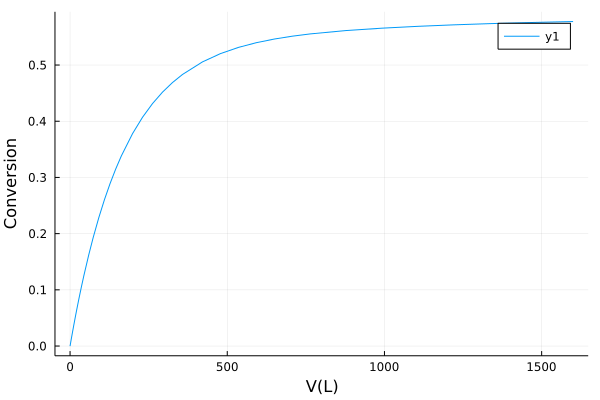

In [86]:
plot(sol.t, conv, xlabel = "V(L)", ylabel = "Conversion")

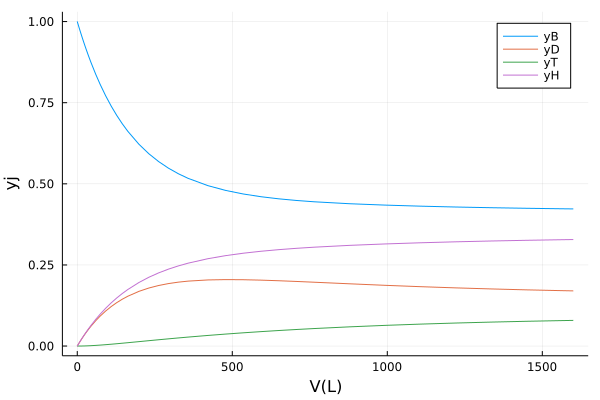

In [87]:
plot(sol.t, [yB, yD, yT, yH], labels = ["yB" "yD" "yT" "yH"], xlabel = "V(L)", ylabel = "yj")

## Automatic Stopping Times

In [88]:
p = SLVector((
    NBf = 60.0e3,
    R = 0.08205,
    T = 1033.0,
    P = 1.0,
    k1 = 7.0e5,
    k2 = 4.0e5,
    K1 = 0.31,
    K2 = 0.48   
        ))

8-element SLArray{Tuple{8}, Float64, 1, 8, (:NBf, :R, :T, :P, :k1, :k2, :K1, :K2)} with indices SOneTo(8):
 :NBf => 60000.0
   :R => 0.08205
   :T => 1033.0
   :P => 1.0
  :k1 => 700000.0
  :k2 => 400000.0
  :K1 => 0.31
  :K2 => 0.48

In [89]:
function xdot!(dext, ext, p, v)
    NB = p.NBf - 2*ext[1] - ext[2]
    ND = ext[1] - ext[2]
    NH = ext[1] + ext[2]
    NT = ext[2]
    Q = p.NBf * p.R * p.T / p.P
    cB = NB / Q
    cD = ND / Q
    cH = NH / Q
    cT = NT / Q
    dext[1] = p.k1 * (cB * cB - cD * cH / p.K1)
    dext[2] = p.k2 * (cB * cD - cT * cH / p.K2)
end

xdot! (generic function with 1 method)

In [96]:
function condition(u, t, integrator)
    conv = (2*u[1] + u[2])/integrator.p.NBf
    conv - 0.5 > 0.0
end

condition (generic function with 1 method)

In [97]:
ext0 = [0.0, 0.0]
vspan = (0.0, 1600.0)
prob = ODEProblem(xdot!, ext0, vspan, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 1600.0)
u0: 2-element Vector{Float64}:
 0.0
 0.0

In [98]:
affect!(integrator) = terminate!(integrator)
cb = DiscreteCallback(condition, affect!)

DiscreteCallback{typeof(condition), typeof(affect!), typeof(DiffEqBase.INITIALIZE_DEFAULT), typeof(DiffEqBase.FINALIZE_DEFAULT)}(condition, affect!, DiffEqBase.INITIALIZE_DEFAULT, DiffEqBase.FINALIZE_DEFAULT, Bool[1, 1])

In [99]:
sol = de.solve(prob, Rodas4(), callback = cb)

retcode: Terminated
Interpolation: specialized 3rd order "free" stiffness-aware interpolation
t: 27-element Vector{Float64}:
   0.0
   9.999999999999999e-5
   0.0010999999999999998
   0.011099999999999997
   0.11109999999999996
   0.41899167885700245
   1.0048478199647597
   1.9542705623327785
   3.4205187637984684
   5.582596679385624
   8.655673963960684
  12.88197439027192
  18.534430710491755
   ⋮
  47.21801944077377
  61.92774301589064
  79.95866223875963
 101.87549911658073
 128.36332979829135
 160.2796165203439
 198.72609726242598
 245.15444897921904
 301.50766328721284
 370.3749718374365
 455.0409919547401
 455.0409919547401
u: 27-element Vector{Vector{Float64}}:
 [0.0, 0.0]
 [0.009744063043051449, 4.521275343295342e-10]
 [0.10718434533613048, 5.470717781052132e-8]
 [1.0815523553813309, 5.570379031926199e-6]
 [10.821752025068879, 0.0005577831816612893]
 [40.771317251152794, 0.007921874101652439]
 [97.59418319232023, 0.04544003075885472]
 [189.22191698055974, 0.17111935483699686

In [100]:
conv = [(2*u[1] + u[2])/p.NBf for u in sol.u]
yB = [(p.NBf - 2*u[1] - u[2])/p.NBf for u in sol.u]
yD = [(u[1] - u[2])/p.NBf for u in sol.u]
yT = [u[2]/p.NBf for u in sol.u]
yH = [(u[1] + u[2])/p.NBf for u in sol.u]

27-element Vector{Float64}:
 0.0
 1.6240105825298306e-7
 1.7864066673884716e-6
 1.802596542933938e-5
 0.000180371830137509
 0.0006796539854209075
 0.0016273270537179847
 0.0031565506055899455
 0.005502389106774626
 0.008926712310028477
 0.013723452601273363
 0.020187511677862306
 0.028598250022939194
 ⋮
 0.06742448737924299
 0.08505699716723107
 0.10479681670035954
 0.12628810722297235
 0.14903686502082514
 0.1724337111390517
 0.19578765178206403
 0.21837414267028166
 0.23949180972115192
 0.25852492835680707
 0.27500974434170605
 0.27500974434170605

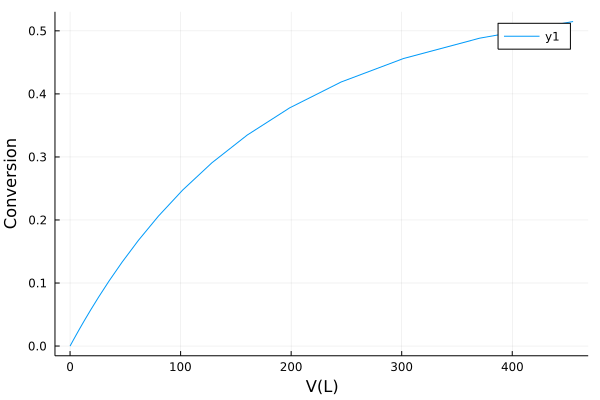

In [101]:
plot(sol.t, conv, xlabel = "V(L)", ylabel = "Conversion")

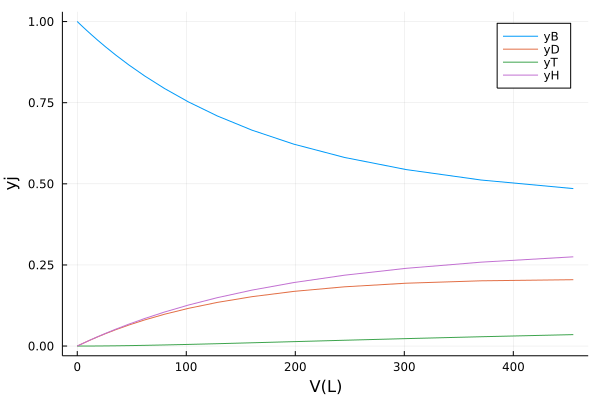

In [102]:
plot(sol.t, [yB, yD, yT, yH], labels = ["yB" "yD" "yT" "yH"], xlabel = "V(L)", ylabel = "yj")

## Parametric Sensitivity of Differential Equations

In [3]:
function rate!(dc, c, p, t)
    dc[1] = -p[1] * c[1]
end

rate! (generic function with 1 method)

In [29]:
tspan = (0.0, 5.0)

(0.0, 5.0)

In [37]:
function cprofile(x)
    prob = ODEProblem(rate!, [x[1]], tspan, [x[2]])
    de.solve(prob, Rodas4(),saveat = 0.1)
end

cprofile (generic function with 1 method)

In [38]:
csol = cprofile([2.0;1.0])
csens = ForwardDiff.jacobian(cprofile,[2.0;1.0])

51×2 Matrix{Float64}:
 1.0          0.0
 0.904837    -0.180968
 0.818731    -0.327493
 0.740818    -0.444491
 0.670321    -0.536252
 0.606531    -0.606532
 0.548813    -0.658565
 0.496585    -0.69522
 0.44933     -0.718918
 0.40657     -0.731821
 0.367879    -0.73576
 0.332874    -0.732299
 0.301195    -0.722861
 ⋮           
 0.0202437   -0.157882
 0.0183162   -0.146522
 0.0165738   -0.135894
 0.0149986   -0.125962
 0.0135734   -0.116689
 0.0122804   -0.108038
 0.0111111   -0.0999786
 0.0100533   -0.0924748
 0.00909672  -0.0854945
 0.00823186  -0.0790061
 0.00744931  -0.0729782
 0.00673962  -0.0673792

In [39]:
csens_analy = hcat([exp(-t) for t in csol.t], [-2.0*t*exp(-t) for t in csol.t])

51×2 Matrix{Float64}:
 1.0         -0.0
 0.904837    -0.180967
 0.818731    -0.327492
 0.740818    -0.444491
 0.67032     -0.536256
 0.606531    -0.606531
 0.548812    -0.658574
 0.496585    -0.695219
 0.449329    -0.718926
 0.40657     -0.731825
 0.367879    -0.735759
 0.332871    -0.732316
 0.301194    -0.722866
 ⋮           
 0.0202419   -0.157887
 0.0183156   -0.146525
 0.0165727   -0.135896
 0.0149956   -0.125963
 0.0135686   -0.11669
 0.0122773   -0.108041
 0.011109    -0.099981
 0.0100518   -0.0924769
 0.00909528  -0.0854956
 0.00822975  -0.0790056
 0.00744658  -0.0729765
 0.00673795  -0.0673795

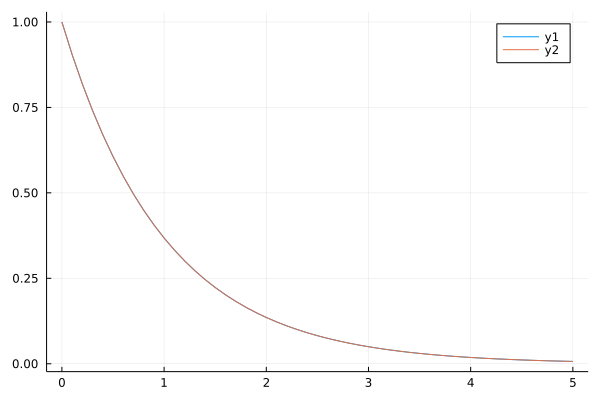

In [42]:
plot(csol.t, [csens[:, 1], csens_analy[:, 1]])

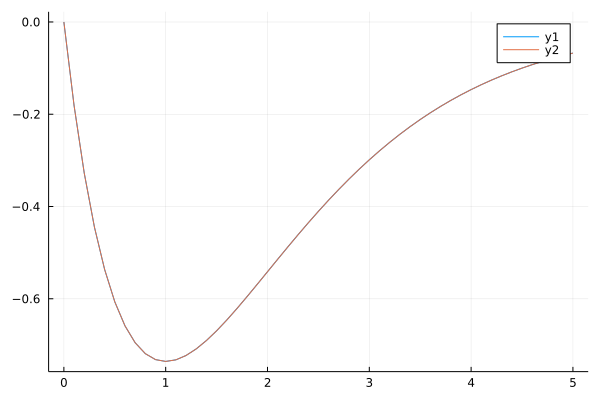

In [44]:
plot(csol.t, [csens[:, 2], csens_analy[:, 2]])